# 1 ARIMA的定义

- AR模型相信“历史决定未来”，因此很大程度上忽略了现实情况的复杂性、也忽略了真正影响标签的因子带来的不可预料的影响。
- 而相对的，MA模型相信“时间序列是相对稳定的，时间序列的波动是由偶然因素影响决定的”，但现实中的时间序列很难一直维持“稳定”这一假设。
- 基于此，ARIMA模型对以上两个模型进行了“组合”，ARIMA模型的基本思想是：一个时间点上的标签值既受过去一段时间内的标签值影响，也受过去一段时间内的偶然事件的影响。即ARIMA模型假设为标签值是围绕着时间的大趋势而波动的，其中趋势是受历史标签影响构成的，波动是受一段时间内的偶然事件影响构成的，且**大趋势本身不一定是稳定**的。在这个中心思想的引导下，ARIMA模型的公式被表示为：

$$
y_{t}=\beta_{0}+\beta_{1}y_{t-1}+\beta_{2}y_{t-2}+\ldots+\beta_{p}y_{t-p}+\epsilon_{t}+\theta_{1}\epsilon_{t-1}+\theta_{2}\epsilon_{t-2}+\ldots+\theta_{q}\epsilon_{t-q}
$$

在这个简单粗暴的公式中，各个变量的含义与MA、AR模型中完全相同，且各个变量的求解方式与原始MA、AR模型基本相同。很明显，公式的前半段是AR模型，后半段是MA模型中关于“波动”的部分。值得注意的是，MA模型中代表长期趋势的均值$ \mu $并不存在于ARIMA模型的公式当中，因为ARIMA模型中“预测长期趋势”这部分功能由AR模型来执行，因此AR模型替代了原本的$ \mu $。在ARIMA模型中，$ \beta_{0} $可以为0。

以上模型被称之为ARIMA(p,d,q)模型，其中p和q的含义与原始MA、AR模型中完全一致，且p和q可以被设置为不同的数值，而d是ARIMA模型需要的差分的阶数。

观察值序列 -> 平稳性检验 -> 白噪声检验 -> 拟合 ARMA 模型

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  
plt.rcParams['axes.unicode_minus'] = False

years = pd.date_range(start='2020-01-01', periods=100, freq='D')
trend = np.linspace(0, 10, 100)
seasonality = 5 * np.sin(np.linspace(0, 10*np.pi, 100))
noise = np.random.randn(100) * 1.5
tax_revenue = trend + seasonality + noise

data = pd.DataFrame({
    'Year': years,
    'Tax_Revenue': tax_revenue
})

print("Original Tax Revenue Data:")
print(data)
print(f"\nData series length: {len(tax_revenue)}")


Original Tax Revenue Data:
         Year  Tax_Revenue
0  2020-01-01    -0.331278
1  2020-01-02    -0.680853
2  2020-01-03     5.321305
3  2020-01-04     4.480989
4  2020-01-05     4.623289
..        ...          ...
95 2020-04-05     5.885672
96 2020-04-06     6.767590
97 2020-04-07    10.421247
98 2020-04-08     7.767503
99 2020-04-09     9.273891

[100 rows x 2 columns]

Data series length: 100


In [32]:

# 2. 平稳性检验（Daniel检验/Spearman秩相关系数）
def daniel_test(series, alpha=0.05):
    """
    Daniel检验序列平稳性
    H0: 序列平稳
    H1: 序列非平稳（存在趋势）
    """
    n = len(series)
    # 计算秩
    ranks = stats.rankdata(series)
    # 计算时间序列的秩
    time_ranks = np.arange(1, n+1)
    
    # 计算Spearman秩相关系数
    qs = stats.spearmanr(time_ranks, ranks)[0]
    
    # 避免除零错误
    if abs(qs) >= 0.9999:
        qs = 0.9999 * np.sign(qs)
    
    # 计算检验统计量
    T = qs * np.sqrt(n - 2) / np.sqrt(1 - qs**2)
    
    # 临界值(ppf 返回分布的第 q 分位数) 此处做双侧检验
    t_critical = stats.t.ppf(1 - alpha/2, n - 2)
    
    print(f"Daniel Stationarity Test Results:")
    print(f"Spearman rank correlation qs = {qs:.4f}")
    print(f"Test statistic T = {T:.4f}")
    print(f"Critical value t_{alpha/2}({n-2}) = {t_critical:.4f}")
    print(f"|T| = {abs(T):.4f} {'>' if abs(T) > t_critical else '<='} {t_critical:.4f}")
    
    if abs(T) > t_critical:
        # 拒绝 H_0, 认为序列非平稳； qs > 0 则有上升趋势; 反之有下降趋势
        trend = "upward trend" if qs > 0 else "downward trend"
        print(f"Reject H0, series is non-stationary with {trend}")
        return False, trend
    else:
        print("Accept H0, series is stationary")
        return True, "no significant trend"

# 检验原始序列平稳性
is_stationary, trend = daniel_test(tax_revenue)

# 3. 一阶差分处理
diff_series = np.diff(tax_revenue)
print(f"\nFirst-order difference series:")
print(f"b_t = a_t - a_(t-1)")
print(f"Difference series: {diff_series}")

# 检验差分序列平稳性
print(f"\nStationarity test for difference series:")
is_diff_stationary, diff_trend = daniel_test(diff_series)


Daniel Stationarity Test Results:
Spearman rank correlation qs = 0.5596
Test statistic T = 6.6840
Critical value t_0.025(98) = 1.9845
|T| = 6.6840 > 1.9845
Reject H0, series is non-stationary with upward trend

First-order difference series:
b_t = a_t - a_(t-1)
Difference series: [-0.3495748   6.00215858 -0.8403162   0.1423003   2.70445304 -4.51385915
  1.40905871 -0.82269363  0.76751415 -0.55398206 -2.01157387 -3.11849022
 -0.51799207 -4.76411353  1.24439489  1.82561716  1.61795656 -0.49128453
  0.37798759  4.28202008  3.22818895 -1.15111412  1.64710061  3.04185114
 -3.96503619  1.95806877 -1.10639883 -0.0834874  -1.7235273  -2.08476579
  0.74022193 -4.04628561 -1.53909787  3.09946454 -1.06554521 -0.15766249
  0.97974157  3.63483779  0.77516119  0.93334222 -0.82844767  4.64342131
 -0.20404174  0.1590694   1.96515809  0.20269762 -4.82814278  1.51802602
  1.96802966 -4.8193361  -1.8468262  -0.56124735 -2.25751152 -1.22951798
  1.25806524  0.751096    1.39075766  4.26067203 -3.3739869   

[-0.3495748   6.00215858 -0.8403162   0.1423003   2.70445304 -4.51385915
  1.40905871 -0.82269363  0.76751415 -0.55398206 -2.01157387 -3.11849022
 -0.51799207 -4.76411353  1.24439489  1.82561716  1.61795656 -0.49128453
  0.37798759  4.28202008  3.22818895 -1.15111412  1.64710061  3.04185114
 -3.96503619  1.95806877 -1.10639883 -0.0834874  -1.7235273  -2.08476579
  0.74022193 -4.04628561 -1.53909787  3.09946454 -1.06554521 -0.15766249
  0.97974157  3.63483779  0.77516119  0.93334222 -0.82844767  4.64342131
 -0.20404174  0.1590694   1.96515809  0.20269762 -4.82814278  1.51802602
  1.96802966 -4.8193361  -1.8468262  -0.56124735 -2.25751152 -1.22951798
  1.25806524  0.751096    1.39075766  4.26067203 -3.3739869   3.17571149
  0.8396255   2.03943717  1.22327384 -0.22479697  1.47351108 -2.07476494
 -0.55326484  1.34292749 -4.47818925 -0.72744678 -0.4445141  -1.56701831
 -0.89858323 -0.46480832  1.58420417 -0.97088055  1.69051366  0.80702168
  2.03072902  4.71559751 -0.6670441   3.32818912 -0

[-0.3495748   6.00215858 -0.8403162   0.1423003   2.70445304 -4.51385915
  1.40905871 -0.82269363  0.76751415 -0.55398206 -2.01157387 -3.11849022
 -0.51799207 -4.76411353  1.24439489  1.82561716  1.61795656 -0.49128453
  0.37798759  4.28202008  3.22818895 -1.15111412  1.64710061  3.04185114
 -3.96503619  1.95806877 -1.10639883 -0.0834874  -1.7235273  -2.08476579
  0.74022193 -4.04628561 -1.53909787  3.09946454 -1.06554521 -0.15766249
  0.97974157  3.63483779  0.77516119  0.93334222 -0.82844767  4.64342131
 -0.20404174  0.1590694   1.96515809  0.20269762 -4.82814278  1.51802602
  1.96802966 -4.8193361  -1.8468262  -0.56124735 -2.25751152 -1.22951798
  1.25806524  0.751096    1.39075766  4.26067203 -3.3739869   3.17571149
  0.8396255   2.03943717  1.22327384 -0.22479697  1.47351108 -2.07476494
 -0.55326484  1.34292749 -4.47818925 -0.72744678 -0.4445141  -1.56701831
 -0.89858323 -0.46480832  1.58420417 -0.97088055  1.69051366  0.80702168
  2.03072902  4.71559751 -0.6670441   3.32818912 -0

[-0.3495748   6.00215858 -0.8403162   0.1423003   2.70445304 -4.51385915
  1.40905871 -0.82269363  0.76751415 -0.55398206 -2.01157387 -3.11849022
 -0.51799207 -4.76411353  1.24439489  1.82561716  1.61795656 -0.49128453
  0.37798759  4.28202008  3.22818895 -1.15111412  1.64710061  3.04185114
 -3.96503619  1.95806877 -1.10639883 -0.0834874  -1.7235273  -2.08476579
  0.74022193 -4.04628561 -1.53909787  3.09946454 -1.06554521 -0.15766249
  0.97974157  3.63483779  0.77516119  0.93334222 -0.82844767  4.64342131
 -0.20404174  0.1590694   1.96515809  0.20269762 -4.82814278  1.51802602
  1.96802966 -4.8193361  -1.8468262  -0.56124735 -2.25751152 -1.22951798
  1.25806524  0.751096    1.39075766  4.26067203 -3.3739869   3.17571149
  0.8396255   2.03943717  1.22327384 -0.22479697  1.47351108 -2.07476494
 -0.55326484  1.34292749 -4.47818925 -0.72744678 -0.4445141  -1.56701831
 -0.89858323 -0.46480832  1.58420417 -0.97088055  1.69051366  0.80702168
  2.03072902  4.71559751 -0.6670441   3.32818912 -0

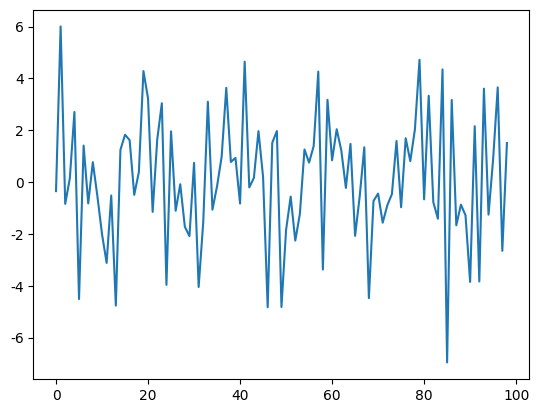

In [33]:

print(diff_series)
plt.plot(diff_series)

In [34]:
adf_test = adfuller(diff_series)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

# print("ADF统计量大于所有三个显著性水平下的临界值，不能拒绝存在单位根的假设")
# print("P 值也远大于 0.05")
# print("所以这个序列在当前形式下是非平稳的")

ADF Statistic: -6.853313867600016
p-value: 1.6727279817620099e-09
Critical Values:
	1%: -3.509
	5%: -2.896
	10%: -2.585


In [35]:
# diff series 仍然不是平稳的，为了后面的分析，假设是平稳的
# 再做白噪声检验
test_ljung_box = sm.stats.diagnostic.acorr_ljungbox(diff_series, lags=[i for i in range(5, 13, 5)])
print("Ljung-Box test statistic:", test_ljung_box.iloc[0, 0])
print("p-value:", test_ljung_box.iloc[0, 1])

# p 值极大，则说明原序列是白噪声

Ljung-Box test statistic: 17.005681405540695
p-value: 0.004489034631239292


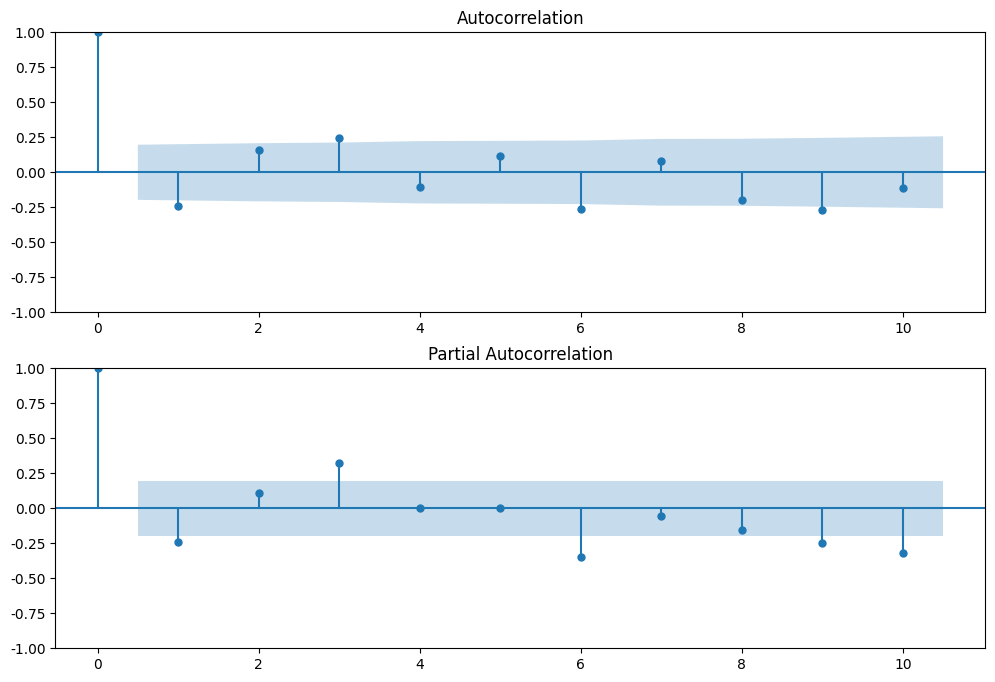

In [36]:

# 模型定阶
# d = 1 已知
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# 截尾比拖尾趋近于0更加迅速
# 截尾在后期不会再有明显的增加。

sm.graphics.tsa.plot_acf(diff_series, lags=10, ax=ax[0])

sm.graphics.tsa.plot_pacf(diff_series, lags=10, ax=ax[1])
plt.show()



# 下图所示，在 lag=1 处有明显负相关，lag=2 稍微正相关，之后逐渐往 0 附近衰减。

# 没有在某个固定阶数后直接“消失”，而是慢慢减小。

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -227.099
Date:                Tue, 26 Aug 2025   AIC                            458.199
Time:                        17:02:56   BIC                            463.389
Sample:                             0   HQIC                           460.299
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2342      0.108     -2.159      0.031      -0.447      -0.022
sigma2         5.7513      0.860      6.684      0.000       4.065       7.438
Ljung-Box (L1) (Q):                   0.05   Jarque-

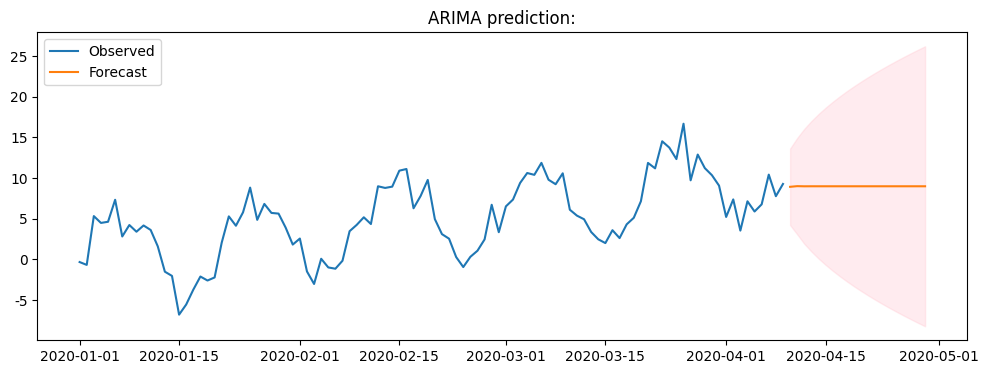

In [ ]:
# p=2, d=1, q=1
model = ARIMA(tax_revenue, order=(1, 1, 0))
results = model.fit()

# 预测阶段
# 如果 ​​95% CI 不包含 0​​ → p 值通常 < 0.05（系数显著）。
# 且越窄越精确
# 根据 p 值, AIC, BIC 来调整参数
print(results.summary())

forecast_steps = 20
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int() # 95% 置信区间

plt.figure(figsize=(12, 4))
plt.plot(data['Year'], data['Tax_Revenue'], label='Observed')

# Get forecast dates
forecast_dates = pd.date_range(data['Year'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

plt.plot(forecast_dates, forecast_mean, label='Forecast')
plt.fill_between(forecast_dates, forecast_ci[:, 0], forecast_ci[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA prediction:')
plt.legend()
plt.show()

# 可以看到越到后面，预测越不可靠（置信区间变大）